In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [17]:
# Step 1: Load cleaned dataset
df_clean = pd.read_csv("Telco-Customer-Churn-Clean.csv")

In [37]:
# Step 2: Split into features (X) and target (y)

X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

In [38]:
# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5634, 6559)
Test shape: (1409, 6559)


In [39]:
# Step 4: Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}


🔹 Logistic Regression
Accuracy: 0.795
ROC-AUC: 0.84
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



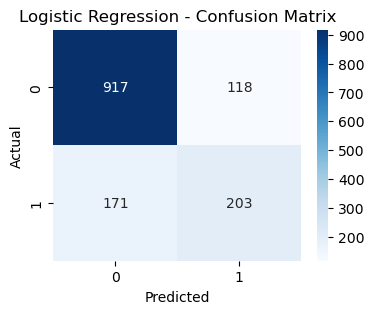


🔹 Random Forest
Accuracy: 0.793
ROC-AUC: 0.83
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1035
           1       0.66      0.46      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



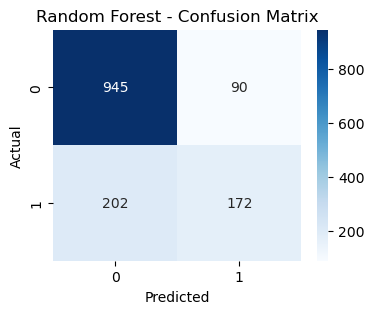

In [51]:
# Step 5: Train and evaluate
results = {}
y = y.astype(int)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {"Estimator": model, "Accuracy": acc, "ROC-AUC": auc, "Report": report}

    print(f"\n🔹 {name}")
    print("Accuracy:", round(acc,3))
    print("ROC-AUC:", round(auc,3))
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [52]:
# Step 6: Compare models
summary = pd.DataFrame({m: {"Accuracy": v["Accuracy"], "ROC-AUC": v["ROC-AUC"]} for m,v in results.items()}).T
print("\n📊 Model Comparison:")
print(summary)


📊 Model Comparison:
                     Accuracy   ROC-AUC
Logistic Regression  0.794890  0.840321
Random Forest        0.792761  0.829678


In [53]:
# Step 7: Save the best model (based on ROC-AUC)
best_model_name = summary['ROC-AUC'].idxmax()
best_model = results[best_model_name]["Estimator"]

joblib.dump(best_model, f"best_churn_model_{best_model_name.replace(' ', '_')}.pkl")
print(f"\n✅ Best model saved as best_churn_model_{best_model_name.replace(' ', '_')}.pkl")


✅ Best model saved as best_churn_model_Logistic_Regression.pkl


C:\Users\sreeh\AppData\Local\Temp\ipykernel_19112\265422811.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")


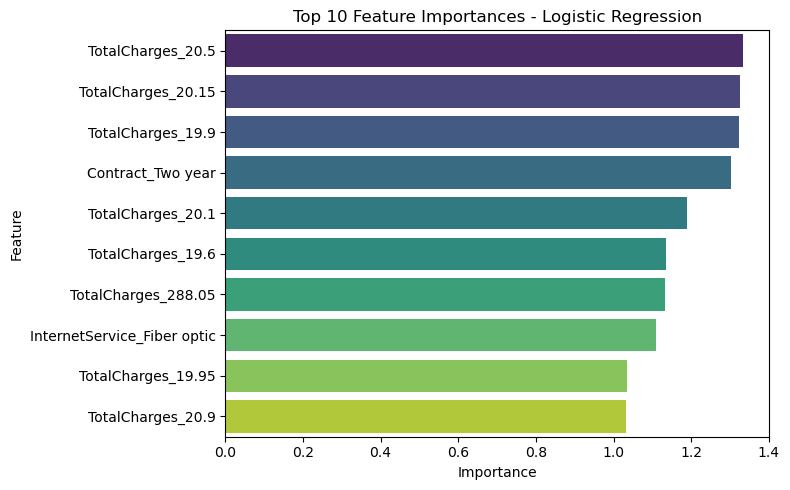

In [57]:

# Step 8: Feature Importance
def plot_feature_importance(model, model_name, X_train):
    if model_name in ["Random Forest", "XGBoost"]:
        # Use feature importances
        importances = model.feature_importances_
        features = X_train.columns
    elif model_name == "Logistic Regression":
        # Use coefficients
        importances = abs(model.coef_[0])
        features = X_train.columns
    else:
        print("Feature importance not supported for this model")
        return
    
    # Create importance DataFrame
    feat_imp = pd.DataFrame({"Feature": features, "Importance": importances})
    feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(10)

    # Plot
    plt.figure(figsize=(8,5))
    sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()

# Plot feature importance for best model
plot_feature_importance(best_model, best_model_name, X_train)

In [59]:
# load the best model
import joblib

# Load the saved best model
best_model = joblib.load("best_churn_model_Logistic_Regression.pkl")  # adjust filename if Logistic Regression won


In [61]:
#Apply model to test data
# Predictions on test set
y_pred = best_model.predict(X_test)

# Prediction probabilities (for churn risk score)
y_prob = best_model.predict_proba(X_test)[:,1]

# Attach predictions to test set
predictions = X_test.copy()
predictions['Actual_Churn'] = y_test.values
predictions['Predicted_Churn'] = y_pred
predictions['Churn_Probability'] = y_prob

# Preview
print(predictions.head())


      SeniorCitizen    tenure  MonthlyCharges  gender_Male  Partner_Yes  \
437       -0.439916  1.613701        1.638143         True         True   
2280       2.273159 -0.992402        1.176164        False        False   
2235      -0.439916  0.351370        0.451620        False         True   
4460      -0.439916 -0.585198        0.446635         True         True   
3761      -0.439916  1.613701        0.594535        False         True   

      Dependents_Yes  PhoneService_Yes  MultipleLines_No phone service  \
437             True              True                           False   
2280           False              True                           False   
2235            True              True                           False   
4460           False              True                           False   
3761           False              True                           False   

      MultipleLines_Yes  InternetService_Fiber optic  ...  \
437                True                    

In [63]:
#Save Predictions
predictions.to_csv("Churn_Predictions.csv", index=False)
print("✅ Predictions saved to Churn_Predictions.csv")


✅ Predictions saved to Churn_Predictions.csv


In [65]:
# 5. Find top 20 highest risk customers
top_risk_customers = predictions.sort_values(by="Churn_Probability", ascending=False).head(20)

print("\n🔹 Top 20 High-Risk Customers:")
print(top_risk_customers[['Actual_Churn','Predicted_Churn','Churn_Probability']])

# 6. Save high-risk customers separately
top_risk_customers.to_csv("Top_20_High_Risk_Customers.csv", index=False)
print("✅ High-risk customers saved to Top_20_High_Risk_Customers.csv")


🔹 Top 20 High-Risk Customers:
      Actual_Churn  Predicted_Churn  Churn_Probability
3380             1                1           0.871112
6866             1                1           0.851358
2631             1                1           0.846941
6894             1                1           0.845256
6365             1                1           0.844379
2797             1                1           0.841023
2464             1                1           0.838651
3727             1                1           0.838170
4585             1                1           0.830798
3346             0                1           0.827207
4039             0                1           0.826284
1731             1                1           0.824028
935              0                1           0.818597
933              1                1           0.817092
582              1                1           0.813715
5019             0                1           0.812811
3956             1                

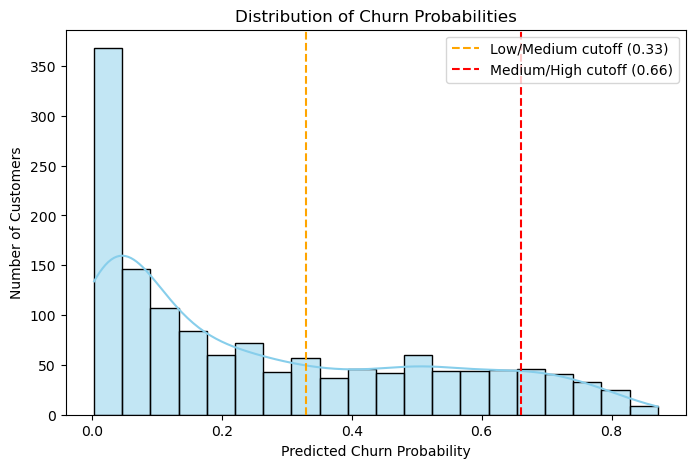


🔹 Customer Distribution by Risk Bucket (%):
Risk_Bucket
Low Risk       64.513840
Medium Risk    24.911285
High Risk      10.574876
Name: proportion, dtype: float64
✅ Predictions with risk buckets saved to Churn_Predictions_With_RiskBuckets.csv


In [67]:
#Churn Proabability Distribution
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot distribution of churn probabilities
plt.figure(figsize=(8,5))
sns.histplot(predictions['Churn_Probability'], bins=20, kde=True, color='skyblue')
plt.axvline(0.33, color='orange', linestyle='--', label='Low/Medium cutoff (0.33)')
plt.axvline(0.66, color='red', linestyle='--', label='Medium/High cutoff (0.66)')
plt.title("Distribution of Churn Probabilities")
plt.xlabel("Predicted Churn Probability")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()

# 2. Assign risk buckets
def risk_bucket(prob):
    if prob < 0.33:
        return "Low Risk"
    elif prob < 0.66:
        return "Medium Risk"
    else:
        return "High Risk"

predictions['Risk_Bucket'] = predictions['Churn_Probability'].apply(risk_bucket)

# 3. Count customers by risk bucket
risk_summary = predictions['Risk_Bucket'].value_counts(normalize=True)*100
print("\n🔹 Customer Distribution by Risk Bucket (%):")
print(risk_summary)

# 4. Save updated predictions with risk buckets
predictions.to_csv("Churn_Predictions_With_RiskBuckets.csv", index=False)
print("✅ Predictions with risk buckets saved to Churn_Predictions_With_RiskBuckets.csv")


C:\Users\sreeh\AppData\Local\Temp\ipykernel_19112\2373550195.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="InternetServiceType", y="Churn_Probability", data=internet_summary, palette="viridis")


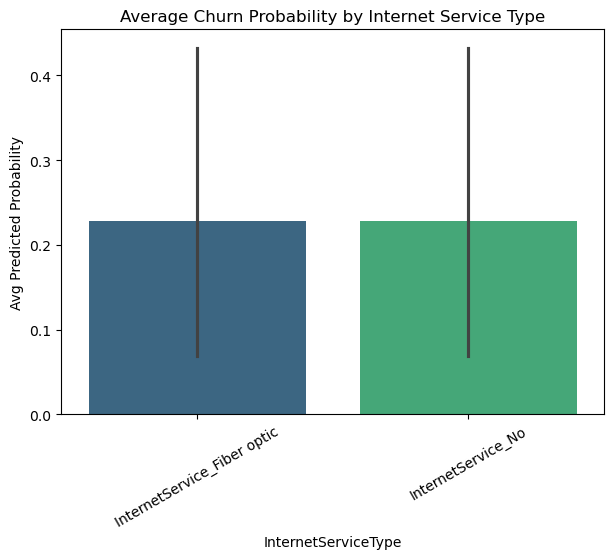

In [69]:
#Churn Probability by Segment
# Example segment: Contract type
if 'Contract_Month-to-month' in X_test.columns:
    # Add back the original categorical from dummy variables if possible
    # Here we’ll use the churn probability directly grouped by a key feature

    # Contract segments from one-hot encoding
    contract_cols = [col for col in X_test.columns if 'Contract' in col]
    
    for col in contract_cols:
        predictions[col] = X_test[col]  # add back to predictions

    # Average churn probability by contract type
    contract_summary = predictions.groupby(contract_cols)['Churn_Probability'].mean().reset_index()

    # Melt to tidy format (for plotting)
    contract_summary = contract_summary.melt(id_vars=['Churn_Probability'], var_name='ContractType')
    
    # Plot
    plt.figure(figsize=(7,5))
    sns.barplot(x="ContractType", y="Churn_Probability", data=contract_summary, palette="coolwarm")
    plt.title("Average Churn Probability by Contract Type")
    plt.ylabel("Avg Predicted Probability")
    plt.xticks(rotation=30)
    plt.show()

# Example segment: Internet Service
internet_cols = [col for col in X_test.columns if 'InternetService' in col]
if internet_cols:
    for col in internet_cols:
        predictions[col] = X_test[col]

    internet_summary = predictions.groupby(internet_cols)['Churn_Probability'].mean().reset_index()
    internet_summary = internet_summary.melt(id_vars=['Churn_Probability'], var_name='InternetServiceType')

    plt.figure(figsize=(7,5))
    sns.barplot(x="InternetServiceType", y="Churn_Probability", data=internet_summary, palette="viridis")
    plt.title("Average Churn Probability by Internet Service Type")
    plt.ylabel("Avg Predicted Probability")
    plt.xticks(rotation=30)
    plt.show()
